# **1. LOAD and PROCESS DATAFRAME STRUCTURES**

## **1.1. Initial load and exploration of dataframe structures:**

In [42]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [43]:
df_title_basics = pd.read_csv('DATA/basics.csv')
print('-'*30,'TABLE df_title_basics:','-'*30,sep='\n')
print(df_title_basics.info())
display(df_title_basics.head())

df_title_ratings = pd.read_csv('DATA/ratings.csv')
print('-'*30,'TABLE df_title_ratings:','-'*30,sep='\n')
print(df_title_ratings.info())
display(df_title_ratings.head())

------------------------------
TABLE df_title_basics:
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86979 entries, 0 to 86978
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tconst          86979 non-null  object 
 1   titleType       86979 non-null  object 
 2   primaryTitle    86978 non-null  object 
 3   originalTitle   86978 non-null  object 
 4   isAdult         86979 non-null  int64  
 5   startYear       86979 non-null  float64
 6   endYear         0 non-null      float64
 7   runtimeMinutes  86979 non-null  int64  
 8   genres          86979 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 6.0+ MB
None


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,NaN,118,"Comedy,Fantasy,Romance"
1,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,0,2020.0,NaN,70,Drama
2,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018.0,NaN,122,Drama
3,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005.0,NaN,100,"Comedy,Horror,Sci-Fi"
4,tt0096056,movie,Crime and Punishment,Crime and Punishment,0,2002.0,NaN,126,Drama


------------------------------
TABLE df_title_ratings:
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71900 entries, 0 to 71899
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         71900 non-null  object 
 1   averageRating  71900 non-null  float64
 2   numVotes       71900 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB
None


,tconst,averageRating,numVotes
0,tt0035423,6.4,87153
1,tt0062336,6.4,175
2,tt0069049,6.7,7754
3,tt0088751,5.2,336
4,tt0096056,5.6,846


In [44]:
# Cheking for Null values
print('-'*30,'Missing values for TABLE df_title_basics:','-'*30,sep='\n')
print(df_title_basics.isna().sum())
print('-'*30,'Missing values for TABLE df_title_ratings:','-'*30,sep='\n')
print(df_title_ratings.isna().sum())

------------------------------
Missing values for TABLE df_title_basics:
------------------------------
tconst                0
titleType             0
primaryTitle          1
originalTitle         1
isAdult               0
startYear             0
endYear           86979
runtimeMinutes        0
genres                0
dtype: int64
------------------------------
Missing values for TABLE df_title_ratings:
------------------------------
tconst           0
averageRating    0
numVotes         0
dtype: int64


- **Table df_title_basics:**
    - **`endYear` will be dropped as a column. => So no problem.**
    - **one missing value within the `primaryTitle` => we will drop this row and the corressponding row in table `df_title_ratings`.**
- **Table df_title_ratings:**
    - **No missing values.** 

In [45]:
# Drop primaryTitle missing values from table basics
df_title_basics = df_title_basics.dropna(subset=['primaryTitle'])
print(df_title_basics.isna().sum())

# adjusting ratings table
#filter ratings table to only include rows drom table basics
filter_left_join_basics_to_ratings_on_tconst = df_title_ratings['tconst'].isin(df_title_basics['tconst'])
df_title_ratings = df_title_ratings[filter_left_join_basics_to_ratings_on_tconst]

tconst                0
titleType             0
primaryTitle          0
originalTitle         0
isAdult               0
startYear             0
endYear           86978
runtimeMinutes        0
genres                0
dtype: int64


In [46]:
#Table basics
# rename columns to match the prerequisites of the stakeholders
columns_mapping_basics ={'tconst':'tconst','primaryTitle':'primary_title','startYear':'start_year','runtimeMinutes':'runtime'}
df_title_basics = df_title_basics.rename(columns_mapping_basics,axis=1)
# drop unncessary columns
df_title_basics = df_title_basics.drop(columns=['titleType','originalTitle','isAdult','endYear',])
print('-'*30,"Table basics:",'-'*30,df_title_basics.columns,sep='\n')

#Table ratings
# rename columns to match the prerequisites of the stakeholders
columns_mapping_ratings ={'tconst':'tconst','averageRating':'average_rating','numVotes':'number_of_votes'}
df_title_ratings = df_title_ratings.rename(columns_mapping_ratings,axis=1)
print('-'*30,"Table ratings:",'-'*30,df_title_ratings.columns,sep='\n')

------------------------------
Table basics:
------------------------------
Index(['tconst', 'primary_title', 'start_year', 'runtime', 'genres'], dtype='object')
------------------------------
Table ratings:
------------------------------
Index(['tconst', 'average_rating', 'number_of_votes'], dtype='object')


## **1.2. Create df_genres dataframe:**

In [47]:
# checking genres values
print(df_title_basics['genres'].value_counts())
print('*'*15)
print('numbers values counts:', df_title_basics['genres'].value_counts().count())

genres
Drama                        17085
Comedy                        7148
Horror                        4071
Comedy,Drama                  4000
Drama,Romance                 2623
                             ...  
Music,Mystery,Romance            1
History,Horror,Mystery           1
Crime,Music,Mystery              1
Crime,Fantasy,Romance            1
Biography,Fantasy,Musical        1
Name: count, Length: 854, dtype: int64
***************
numbers values counts: 854


- **We can see that each movie can have multiple genres. We will split each row**

In [48]:
#d = pd.DataFrame(df_title_basics['genres'].tolist()).add_prefix('genres')
#d = df[['First Name', 'Last Name']] = df_title_basics['genres'].str.split(' ', expand=True)
# count the max number of genres per title by counting the number_of_comms+1
max_genres_per_title = df_title_basics['genres'].str.count(',').max() + 1
print('max_genres_per_title = ',max_genres_per_title)

max_genres_per_title =  3


In [49]:
df_title_basics[['genre_0','genre_1','genre_2']] = df_title_basics['genres'].str.split(',', expand=True)
df_title_basics.info()
df_title_basics.head()

<class 'pandas.core.frame.DataFrame'>
Index: 86978 entries, 0 to 86978
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         86978 non-null  object 
 1   primary_title  86978 non-null  object 
 2   start_year     86978 non-null  float64
 3   runtime        86978 non-null  int64  
 4   genres         86978 non-null  object 
 5   genre_0        86978 non-null  object 
 6   genre_1        49281 non-null  object 
 7   genre_2        26340 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 6.0+ MB


,tconst,primary_title,start_year,runtime,genres,genre_0,genre_1,genre_2
0,tt0035423,Kate & Leopold,2001.0,118,"Comedy,Fantasy,Romance",Comedy,Fantasy,Romance
1,tt0062336,The Tango of the Widower and Its Distorting Mi...,2020.0,70,Drama,Drama,None,None
2,tt0069049,The Other Side of the Wind,2018.0,122,Drama,Drama,None,None
3,tt0088751,The Naked Monster,2005.0,100,"Comedy,Horror,Sci-Fi",Comedy,Horror,Sci-Fi
4,tt0096056,Crime and Punishment,2002.0,126,Drama,Drama,None,None


In [50]:
genre_name = pd.concat([df_title_basics['genre_0'],df_title_basics['genre_1'],df_title_basics['genre_2']],ignore_index=True)
print('duplicated values in genre_name: ',genre_name.duplicated().sum())
genre_name = genre_name.drop_duplicates()
print('unique values in genre_name: ',genre_name.nunique())

duplicated values in genre_name:  260908
unique values in genre_name:  25


In [51]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(genre_name)
print(list(le.classes_))
genre_id = le.transform(genre_name)
df_genres = pd.DataFrame({'genre_id':genre_id,'genre_name':genre_name}).reset_index(drop=True)
df_genres = df_genres.dropna()
df_genres.sort_values(by=['genre_id'])

['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western', None]


,genre_id,genre_name
4,0,Action
11,1,Adult
6,2,Adventure
8,3,Animation
2,4,Biography
0,5,Comedy
5,6,Crime
1,7,Drama
14,8,Family
10,9,Fantasy


## **1.3. Create data type dictionaries:**

In [52]:
df_title_basics = df_title_basics.drop(columns=['genre_0','genre_1','genre_2'])

In [53]:
# Check variable types:
print('-'*30,'Table basics_DATA TYPES:','-'*30,sep='\n')
print(df_title_basics.dtypes)
print('-'*30,'Table ratings_DATA TYPES:','-'*30,sep='\n')
print(df_title_ratings.dtypes)
print('-'*30,'Table genres_DATA TYPES:','-'*30,sep='\n')
print(df_genres.dtypes)

------------------------------
Table basics_DATA TYPES:
------------------------------
tconst            object
primary_title     object
start_year       float64
runtime            int64
genres            object
dtype: object
------------------------------
Table ratings_DATA TYPES:
------------------------------
tconst              object
average_rating     float64
number_of_votes      int64
dtype: object
------------------------------
Table genres_DATA TYPES:
------------------------------
genre_id       int32
genre_name    object
dtype: object


In [54]:
# change start_year to datetime
df_title_basics['start_year'] = pd.to_datetime(df_title_basics['start_year'])

In [55]:
# Cheking lengths of object types
print('-'*30,'Table basics_MAX LENGTH OF STRING TYPES:','-'*30,sep='\n')
for col in df_title_basics.select_dtypes('object').columns:
    print(f'maximum lenghth of {col} = {df_title_basics[col].map(len).max()}')
print('-'*30,'Table ratings_MAX LENGTH OF STRING TYPES:','-'*30,sep='\n')
for col in df_title_ratings.select_dtypes('object').columns:
    print(f'maximum lenghth of {col} = {df_title_ratings[col].map(len).max()}')
print('-'*30,'Table genres_MAX LENGTH OF STRING TYPES:','-'*30,sep='\n')
for col in df_genres.select_dtypes('object').columns:
    print(f'maximum lenghth of {col} = {df_genres[col].map(len).max()}')

------------------------------
Table basics_MAX LENGTH OF STRING TYPES:
------------------------------
maximum lenghth of tconst = 10
maximum lenghth of primary_title = 242
maximum lenghth of genres = 29
------------------------------
Table ratings_MAX LENGTH OF STRING TYPES:
------------------------------
maximum lenghth of tconst = 10
------------------------------
Table genres_MAX LENGTH OF STRING TYPES:
------------------------------
maximum lenghth of genre_name = 10


In [58]:
# Cheking numeric types
print('-'*30,'Table basics_NUMERIC TYPES:','-'*30,sep='\n')
display(df_title_basics.describe())
print('-'*30,'Table ratings_NUMERIC TYPES:','-'*30,sep='\n')
display(df_title_ratings.describe())
print('-'*30,'Table genres_NUMERIC TYPES:','-'*30,sep='\n')
display(df_genres.describe())

------------------------------
Table basics_NUMERIC TYPES:
------------------------------


,start_year,runtime
count,86978,86978.000000
mean,1970-01-01 00:00:00.000002013,95.040229
min,1970-01-01 00:00:00.000002,2.000000
25%,1970-01-01 00:00:00.000002009,83.000000
50%,1970-01-01 00:00:00.000002014,92.000000
75%,1970-01-01 00:00:00.000002018,105.000000
max,1970-01-01 00:00:00.000002022,1669.000000
std,NaN,27.808289


------------------------------
Table ratings_NUMERIC TYPES:
------------------------------


,average_rating,number_of_votes
count,71900.000000,7.190000e+04
mean,5.825081,9.924410e+03
std,1.408815,5.841452e+04
min,1.000000,5.000000e+00
25%,5.000000,5.400000e+01
50%,6.000000,2.540000e+02
75%,6.800000,1.415000e+03
max,10.000000,2.741213e+06


------------------------------
Table genres_NUMERIC TYPES:
------------------------------


,genre_id
count,25.000000
mean,12.000000
std,7.359801
min,0.000000
25%,6.000000
50%,12.000000
75%,18.000000
max,24.000000


In [63]:
# construct dictionary of types
from sqlalchemy.types import VARCHAR, INT, DECIMAL, DATE, DATETIME

print('-'*30,'Table basics_DATATYPE DICTIONARY:','-'*30,sep='\n')
basic_dtypes = {
    'tconst': VARCHAR(10),
    'primary_title': VARCHAR(250),
    'start_year': DATE,
    'runtime': DECIMAL(6,2), # 2 for nbr of digits after decimal points (max 60 secs) and 3 digits before decimal points (max 9999 minutes) (total of 5 digits)
    'genres': VARCHAR(54) #5 times maximum length of genre_name which means max of 5 genres per title + 4 commas
    }
print(basic_dtypes)

print('-'*30,'Table ratings_DATATYPE DICTIONARY:','-'*30,sep='\n')
rating_dtypes = {
    'tconst': VARCHAR(10),
    'average_rating': DECIMAL(5,3), # max 10, min 1 and 3 digits after decimal point, total of
    'number_of_votes': INT # number of votes > 0
    }
print(rating_dtypes)

print('-'*30,'Table genres_DATATYPE DICTIONARY:','-'*30,sep='\n')
genre_dtypes = {
    'genre_id': VARCHAR(10),
    'genre_name': VARCHAR(10) # max 10, min 1 and 3 digits after decimal point, total of
    }
print(genre_dtypes)


------------------------------
Table basics_DATATYPE DICTIONARY:
------------------------------
{'tconst': VARCHAR(length=10), 'primary_title': VARCHAR(length=250), 'start_year': <class 'sqlalchemy.sql.sqltypes.DATE'>, 'runtime': DECIMAL(precision=6, scale=2), 'genres': VARCHAR(length=54)}
------------------------------
Table ratings_DATATYPE DICTIONARY:
------------------------------
{'tconst': VARCHAR(length=10), 'average_rating': DECIMAL(precision=5, scale=3), 'number_of_votes': <class 'sqlalchemy.sql.sqltypes.INTEGER'>}
------------------------------
Table genres_DATATYPE DICTIONARY:
------------------------------
{'genre_id': VARCHAR(length=10), 'genre_name': VARCHAR(length=10)}


# **2. DATABASE DESIGN_ERD:**

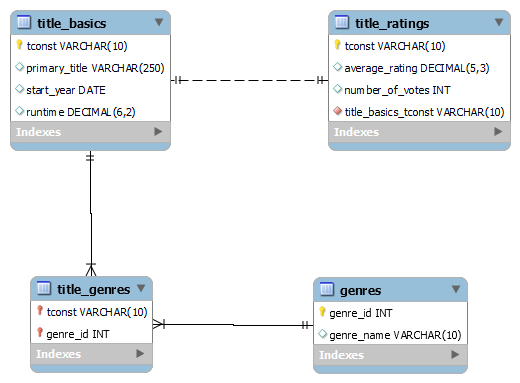

# **3. INSERT DATA to DATABASE with Python _*only basics and ratings*:**